In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def apply_gabor_filters(image, scales, orientations):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    responses = []
    scores = []

    for scale in scales:
        for orientation in orientations:
            # Apply Gabor filter
            gabor_kernel = cv2.getGaborKernel(
                (scale, scale),  # Size of the filter
                5.0,  # Standard deviation of the Gaussian envelope
                orientation,  # Orientation of the normal to the Gabor function
                10.0,  # Wavelength of the sinusoidal factor
                0.8,  # Spatial aspect ratio
                0,  # Phase offset
                ktype=cv2.CV_32F
            )

            gabor_response = cv2.filter2D(gray_image, cv2.CV_32F, gabor_kernel)
            responses.append(gabor_response)

    return responses

In [3]:
def compute_texturization_percentage(image, responses, visualize = False, threshold=0.5):
    # Normalize each response separately
    normalized_responses = [np.abs(response) / np.max(np.abs(response)) for response in responses]

    # Find the highest value for each pixel across all responses
    max_responses = np.max(np.stack(normalized_responses), axis=0)

    # Count the number of pixels above the threshold
    above_threshold_pixels = np.sum(max_responses > threshold)

    # Compute the percentage of heavily texturized pixels
    total_pixels = np.prod(max_responses.shape)
    percentage_texturized = (above_threshold_pixels / total_pixels) * 100
    if visualize:
        visualize_above_threshold_and_max_response(image, max_responses)

    return percentage_texturized, max_responses

In [4]:
def visualize_above_threshold_and_max_response(image, max_responses):
    fig, axes = plt.subplots(1, 1, figsize=(7, 3))

    # Max Response
    axes.imshow(max_responses)
    axes.set_title('Max Response')
    axes.axis('off')


    plt.tight_layout()
    plt.show()

In [5]:
def visualize_response_map(responses, scales, orientations):
    num_scales = len(scales)
    num_orientations = len(orientations)

    fig, axes = plt.subplots(num_scales, num_orientations, figsize=(12, 12))

    for i in range(num_scales):
        for j in range(num_orientations):
            index = i * num_orientations + j
            ax = axes[i, j] if num_scales > 1 else axes[j]

            response = responses[index]

            ax.imshow(response)
            ax.set_title(f'Scale: {scales[i]}, Orientation: {orientations[j]}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()


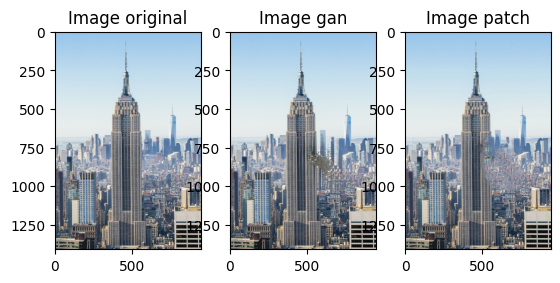

(1408, 944, 3) (1408, 944, 3) (1408, 944, 3)


In [6]:
image_GAN_path = 'examples/inpaint/empire_gan.png'
image_patch_path =  'examples/inpaint/empire_patch.png'
image_original_path =  'examples/inpaint/empire.jpg'

image_original = cv2.imread(image_original_path)
pixels_to_remove_x = 4
pixels_to_remove_y = 6
image_original = image_original[:-pixels_to_remove_y, :-pixels_to_remove_x]

image_GAN = cv2.imread(image_GAN_path)

#image_GAN = cv2.resize(image_GAN, (image_original.shape[1], image_original.shape[0]))
image_patch = cv2.imread(image_patch_path)
image_patch = image_patch[:-pixels_to_remove_y, :-pixels_to_remove_x]

image_original = cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB)
image_GAN = cv2.cvtColor(image_GAN, cv2.COLOR_BGR2RGB)
image_patch = cv2.cvtColor(image_patch, cv2.COLOR_BGR2RGB)

plt.subplot(1, 3, 1)
plt.imshow(image_original)
plt.title('Image original')

plt.subplot(1, 3, 2)
plt.imshow(image_GAN)
plt.title('Image gan')

plt.subplot(1, 3, 3)
plt.imshow(image_patch)  # Use a suitable colormap
plt.title('Image patch')

plt.show()

print(image_original.shape, image_GAN.shape, image_patch.shape)

In [7]:
scales = [2]
orientations = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4]


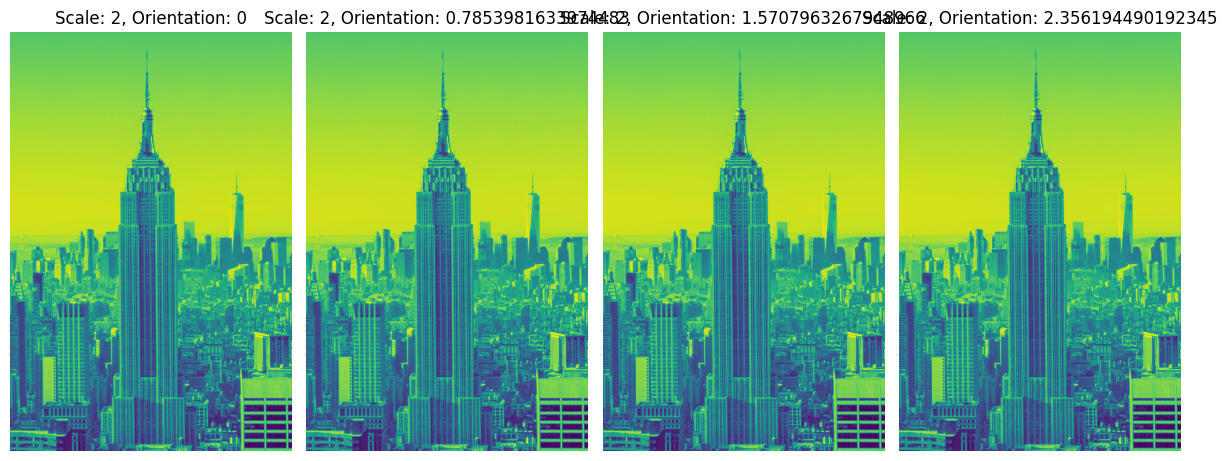

In [8]:
responses_original = apply_gabor_filters(image_original, scales, orientations)
responses_GAN = apply_gabor_filters(image_GAN, scales, orientations)
responses_patch = apply_gabor_filters(image_patch, scales, orientations)

visualize_response_map(responses_original, scales, orientations)

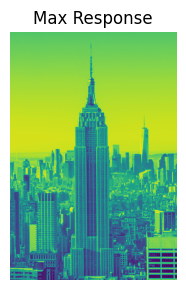

Texturization Score: 73.42215186825885


In [9]:
# Compute texturization score
score, max_response_original = compute_texturization_percentage(image_original, responses_original, True)
print(f'Texturization Score: {score}')

In [10]:
score, max_response_GAN = compute_texturization_percentage(image_GAN, responses_GAN)
print(f'Texturization Score: {score}')

Texturization Score: 73.1763560525809


In [11]:
score, max_response_patch = compute_texturization_percentage(image_patch, responses_patch)
print(f'Texturization Score: {score}')

Texturization Score: 75.76364479006163


In [12]:
def test1_higher_pixel(responsesImage1, responsesImage2, image1, image2):
    selected_responses = np.zeros_like(image1)  # Initialize with zeros

    for i in range(responsesImage1.shape[0]):  # iterate over rows
        for j in range(responsesImage1.shape[1]):  # iterate over columns
            # Access the pixel value at the current position (i, j)
            response1 = responsesImage1[i, j]
            response2 = responsesImage1[i,j]
            if response1 > response2:
               selected_responses[i,j,:] = image1[i,j, :] 
            else:
                selected_responses[i,j,:] = image2[i,j, :] 
    plt.subplot(1, 1, 1)
    plt.imshow(selected_responses, cmap='gray')
    plt.title('Image 1')


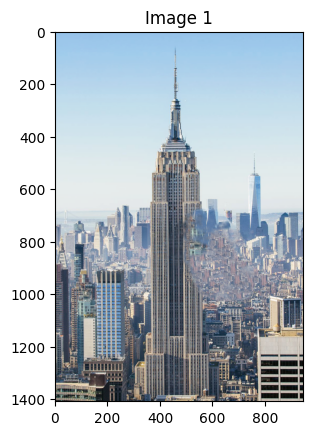

In [13]:
test1_higher_pixel(max_response_GAN, max_response_patch, image_GAN, image_patch)

In [14]:
def test2_combination(responsesImage1, responsesImage2, image1, image2):
    selected_responses = np.zeros_like(image1)  # Initialize with zeros

    for i in range(responsesImage1.shape[0]):  # iterate over rows
        for j in range(responsesImage1.shape[1]):  # iterate over columns
            # Access the pixel value at the current position (i, j)
            response1 = responsesImage1[i, j]
            response2 = responsesImage1[i,j]
            normalized_1 = response1 / (response1 + response2)
            normalized_2 = response2 / (response1 + response2)
            
            selected_responses[i,j,:] = image1[i,j, :] * normalized_1 +   image2[i,j, :] * normalized_2
     
    plt.subplot(1, 1, 1)
    plt.imshow(selected_responses, cmap='gray')
    plt.title('Image 1')
    cv2.imwrite('./test2_combination.png', cv2.cvtColor(selected_responses, cv2.COLOR_RGB2BGR))
  


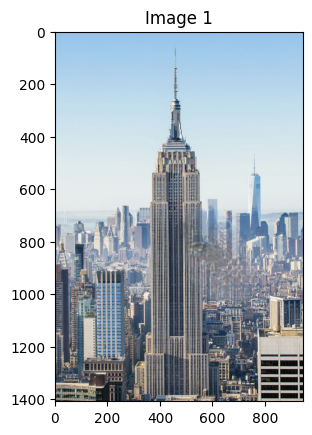

In [15]:
test2_combination(max_response_GAN, max_response_patch, image_GAN, image_patch)

In [16]:
def test3_original_decides(responsesImageOriginal, image1, image2):
    selected_responses = np.zeros_like(image1)  # Initialize with zeros

    for i in range(responsesImageOriginal.shape[0]):  # iterate over rows
        for j in range(responsesImageOriginal.shape[1]):  # iterate over columns
            # Access the pixel value at the current position (i, j)
            response = responsesImageOriginal[i, j]
            if response > 0.5:
                selected_responses[i,j,:] = image2[i,j, :]
            else:
                selected_responses[i,j,:] = image1[i,j, :]
     
    plt.subplot(1, 1, 1)
    plt.imshow(selected_responses, cmap='gray')
    plt.title('Image 1')
    cv2.imwrite('./test3_original_decides.png', cv2.cvtColor(selected_responses, cv2.COLOR_RGB2BGR))
  


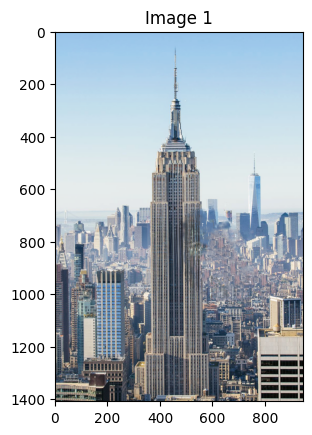

In [17]:
test3_original_decides(max_response_original, image_GAN, image_patch)